# MNIST Classification - Kernel Regression

## Importing packages & data

In [176]:
# Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

import pickle
from tqdm import tqdm


In [177]:
# Importing data
dl_path = './MNIST'

# Run first time to download dataset
#mnist = fetch_openml('mnist_784', version=1, data_home=dl_path)

# After fetching and processing for the first time
#with open('./MNIST/mnist_processed.pkl', 'wb') as f:
#    pickle.dump(mnist, f)

# Pickled data for quick retrieval
with open('./MNIST/mnist_processed.pkl', 'rb') as f:
    mnist = pickle.load(f)

## Classification with kernel regression & PCA

Kernel regression is a classical ML method for classification tasks. We begin by reducing the dimensionality of our data using PCA, then use a grid search to find optimal kernel parameters. 

### Prepping data
- Resampling (undersampling to ensure equal distribution of labels)
- Splitting into train/test
- Scaling data to normalize
- Applying PCA

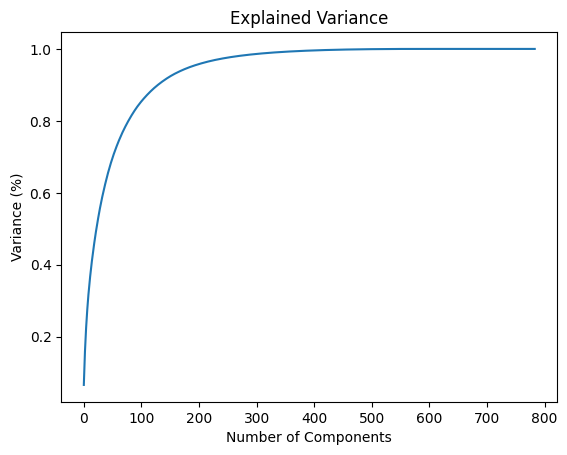

Number of components for 95% variance:  186


In [178]:
# Splitting into train/test data
X, y = mnist["data"], mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, random_state=42, stratify=y)

X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

# Undersampling training set to remove sampling bias
unique, counts = np.unique(y_train, return_counts=True)
min_samples = min(counts)

sample_ids = []
for u in unique :
    class_samples = y_train[y_train == u].index.to_numpy()

    random_indices = np.random.choice(len(class_samples), min_samples, replace=False)
    sample_ids.extend(class_samples[random_indices])

X_train, y_train = X_train.iloc[sample_ids], y_train.iloc[sample_ids]

# Scaling features
scaler = StandardScaler()
train_features = scaler.fit_transform(X_train)
test_features = scaler.transform(X_test)

# Applying PCA and visualizing explained variance
pca = PCA().fit(train_features)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

# Keeping modes for 95% variance
pca_95 = PCA(0.95)  # 0.95 is the explained variance we want to preserve
train_features = pca_95.fit_transform(train_features)
test_features = pca_95.transform(test_features)

print("Number of components for 95% variance: ", pca_95.n_components_)

## Building classifier
We will use a one-versus-rest (OvR) classification method, i.e. we create separate classifiers for each digit. 

In [179]:
digits = '0123456789'
classifiers = []

params = {'alpha': np.linspace(0.001, 0.1, 5), 
          'gamma': np.linspace(0.0001, 0.01, 5)}

for digit in tqdm(digits):
    kr = GridSearchCV(KernelRidge(kernel='rbf'), param_grid=params, cv=5)
    kr.fit(train_features, (y_train == digit).astype(int))

    classifiers.append(kr)

# Building classification function
def classify(X) : 
    return np.array([kr.predict(X.reshape(1,-1)) for kr in classifiers]).argmax()

100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


## Testing performance

In [180]:
results = []
n_samples = int(1e3)
sample_ids = np.random.choice(test_features.shape[0], n_samples, replace=False)
for sample in tqdm(test_features[sample_ids]) : 
    results.append(classify(sample))

results = np.array(results)
accuracy = (results == y_test[sample_ids].astype(int)).sum()/results.shape[0]
missed_labels = np.where(results != y_test[sample_ids].astype(int))[0]

print(f"Accuracy: {accuracy}")

100%|██████████| 1000/1000 [00:02<00:00, 364.90it/s]

Accuracy: 0.889


In [184]:
missed_labels

array([ 21,  32,  49,  52,  58,  66,  79,  87,  94, 100, 102, 117, 125,
       131, 132, 149, 156, 160, 161, 170, 171, 176, 182, 185, 186, 192,
       222, 223, 241, 256, 278, 284, 301, 306, 324, 326, 337, 340, 348,
       359, 364, 374, 376, 377, 379, 394, 409, 414, 416, 419, 445, 446,
       451, 471, 493, 517, 522, 528, 558, 567, 573, 589, 591, 598, 615,
       622, 629, 631, 651, 655, 664, 667, 675, 689, 690, 693, 710, 720,
       726, 735, 742, 746, 754, 758, 771, 772, 773, 794, 822, 828, 854,
       855, 876, 885, 886, 904, 911, 917, 919, 922, 924, 928, 943, 950,
       961, 967, 974, 980, 981, 984, 997])

Label: 8. Classified: 8.


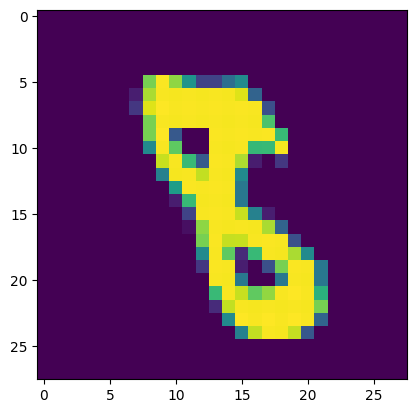

In [185]:
# Visualizing given test samples
n = 21
plt.imshow(X_test.iloc[n].to_numpy().reshape(28,28))
print(f"Label: {y_test.iloc[n]}. Classified: {classify(test_features[n])}.")

### Quick detour: Exploring PCA

In [156]:
pca_2 = PCA(2)
X_fitted = pca_2.fit_transform(X_train)


In [187]:
pca_2 = PCA(25)
X_fitted = pca_2.fit_transform(X_train)

pc1_min, pc1_max, pc2_min, pc2_max = X_fitted[:,0].min(), X_fitted[:,0].max(), X_fitted[:,1].min(), X_fitted[:,1].max()
pc1, pc2 = np.meshgrid(np.linspace(pc1_min, pc1_max, 100), np.linspace(pc2_min, pc2_max, 100))



In [193]:
from sklearn.neighbors import NearestNeighbors

# Fit NearestNeighbors with X_fitted
nn = NearestNeighbors(n_neighbors=1).fit(X_fitted)

# Create an array of points from the meshgrid
mesh_points = np.c_[pc1.ravel(), pc2.ravel()]

# Find the nearest neighbors from X_fitted for each point in mesh_points
distances, indices = nn.kneighbors(mesh_points)

# If you want to get the coordinates of the nearest points, you can do the following:
nearest_points = X_fitted[indices.ravel()]


In [200]:
mesh_points

array([[ -9.35756015, -17.48024544],
       [ -8.94097693, -17.48024544],
       [ -8.52439371, -17.48024544],
       ...,
       [ 31.05101218,  28.34962041],
       [ 31.4675954 ,  28.34962041],
       [ 31.88417862,  28.34962041]])

In [201]:
nearest_points 

array([[ -2.65851247, -12.57706648],
       [ -2.65851247, -12.57706648],
       [ -2.65851247, -12.57706648],
       ...,
       [ 21.77057279,  25.01713753],
       [ 21.77057279,  25.01713753],
       [ 21.77057279,  25.01713753]])

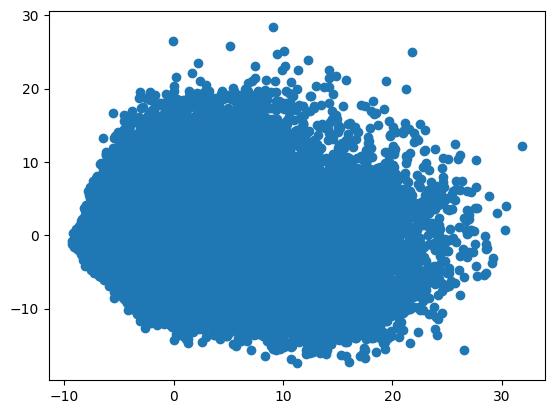

In [203]:
nearest_points